This is the notebook I used for measuring line fluxes. Honestly it is kind of rudimentary and I could have just used some other existing package but I include it here for transparency.

The list 'check_lines' is where you input the wavelength in Angstroms of the line(s) you'd like to measure. 
The code does a preliminary fit of the continuum with a polynomial, with the degree chosen by the user. In the variable 'mask' you can add whatever wavelengths in Angstroms you do not want to be considered in the fit, eg. because there is another emission line there.

After doing this, you can then choose the left and right bounds on the integration (in Angstroms). The code then runs a pyspeckit routine to fit the baseline, and outputs the plot of this. If the baseline fit looks sensible, you can then input this value as 'baseline_value' to have it subtracted before doing the integration. Note the baseline could be negative if the original continuum was overestimated. The code also asks the user once more for the left/right bounds of the line, in case the user wants to adjust those.

Finally, the code performs an integration over the line 50x, doing a Monte Carlo iteration over the spectral flux uncertainty. It outputs the average and standard deviation of these 50 measurements, and plots a histogram showing the distribution of flux measurements around the mean.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
import astropy.units as u
from astropy.nddata import StdDevUncertainty
from astropy.visualization import quantity_support
quantity_support()
from astropy.table import Table

import pyspeckit as p
from scipy.interpolate import interp1d
from scipy.stats import norm

from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import line_flux
from specutils.fitting import find_lines_threshold

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
ysoname = '2MASS J03285101+3118184'

#wavelength of lines in Angstroms
beta = 4860
gamma = 4340
delta = 4102
H = 3969
K = 3934

#select whichever ones you want to measure
check_lines = [gamma]

In [3]:
def fit_continuum(wave, flux, degree, mask, plot=True):
    y=np.array(flux)
    fit_wave = []
    fit_flux = []
    for n in range(0, len(flux)): 
        if wave[n] not in mask:
            fit_wave.append(wave[n])
            fit_flux.append(flux[n])
    z = np.polyfit(fit_wave, fit_flux, degree)
    m = np.poly1d(z)
    y_1 = np.array(m(wave))
    result = np.array(y-y_1)

    if plot==True:
        plt.plot(wave, flux)
        for i in mask:
            plt.axvline(x=i, c = 'r', alpha=0.1)
        plt.axvline(x=0, c = 'r', alpha=0.1, label='masked from continuum fit')
        plt.plot(wave, flux, c='b', label='data')
        plt.plot(fit_wave, m(fit_wave), c='g', label = 'approximate continuum fit')
        plt.xlim(np.min(wave),np.max(wave))
        plt.ylim(np.min(flux),np.max(flux))
        plt.legend()
        plt.show()    

    return result

In [4]:
def measure_line_flux(y, x, e, exclude_min,exclude_max, n, baseline, degree, mask):
    y2 = y.copy()
    fluxes = np.zeros(n)
    wavenew= np.arange(exclude_min-5, exclude_max+5, .01) #wavelength in immediate vincinity of line

    #monte carlo with n iterations
    for w in range(n):
        y2 = y + np.random.randn(len(y))*e #
        #this is where the continuum subtraction happens now
        continuum_subt = fit_continuum(x, y2, degree, mask, plot=False) - baseline
        f = interp1d(x, continuum_subt, kind='cubic')
        y2_spec = Spectrum1D(flux= (f(wavenew)) * u.Unit('erg cm-2 s-1 AA-1'), spectral_axis=wavenew*u.AA) #replaced continuum_subt with f(wavenew)
        dist = line_flux(y2_spec, regions=SpectralRegion(exclude_min*u.AA, exclude_max*u.AA))
        chars_1 = (str(dist).split())
        fluxes[w] = float(chars_1[0])
       
    mu,sigma = norm.fit(fluxes) 
    #print(fluxes)
    plt.figure()
    print('average: ', mu, 'erg/s/cm2/A ', 'sigma: ', sigma, 'erg/s/cm2/A ')
    n,bins,patches = plt.hist(fluxes, 20, facecolor='green', histtype='stepfilled')
    plt.ylabel('number of samples')
    plt.xlabel('line flux')  
    plt.grid(True)         
    plt.show()
    return mu, sigma

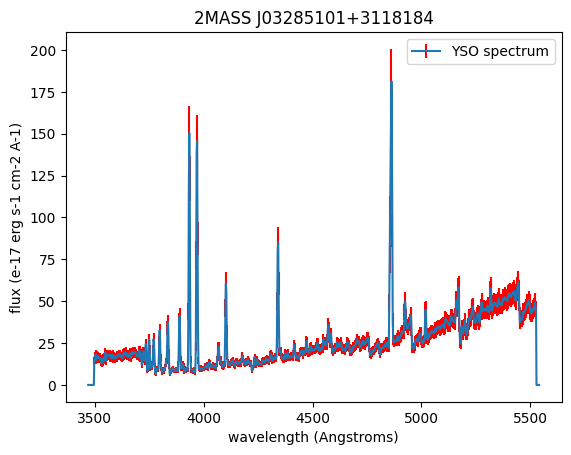

In [6]:
#initializing
wave = np.arange(3470, 5542, 2) #angstroms
#data_table = Table.read('example_VIRUS_spectra/2MASS_J03285101+3118184.fits')
data_table = Table.read('2MASS_J03285101+3118184.fits')
flux_YSO, flux_YSO_err = data_table['flux (erg/s/cm2)']*1e-17, data_table['error']*1e-17 #in units of erg/s/cm2/A

plt.errorbar(wave, flux_YSO * 1e17, yerr= flux_YSO_err * 1e17, ecolor = 'red', label = 'YSO spectrum')
plt.xlabel('wavelength (Angstroms)')
plt.ylabel('flux (e-17 erg s-1 cm-2 A-1)')
plt.title(ysoname)
plt.legend()

In [7]:
#this is to mask out wavelengths at/near other emission lines, so they don't become a part of the fit to the continuum

mask = []
high_balmer = [4860, 4340, 4102, 5000, 3890, 3836, 3799, 3770, 3751, 3934, 3970, 3890, 3836, 3798, 3770, 3750, 3734, 4470, 4230, 4240]
for j in high_balmer:
    for n in range(0, len(wave)):
        if (wave[n]) in range(j-15, j+20):
            mask.append(wave[n])

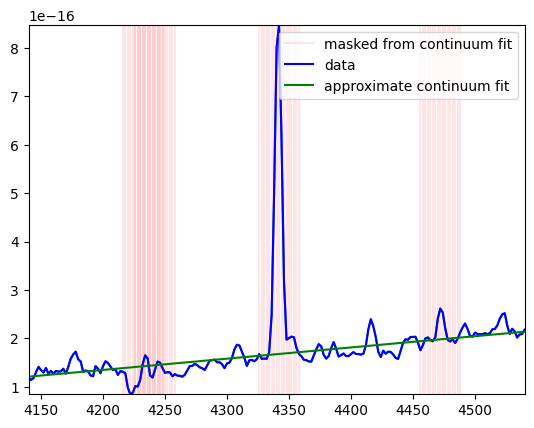

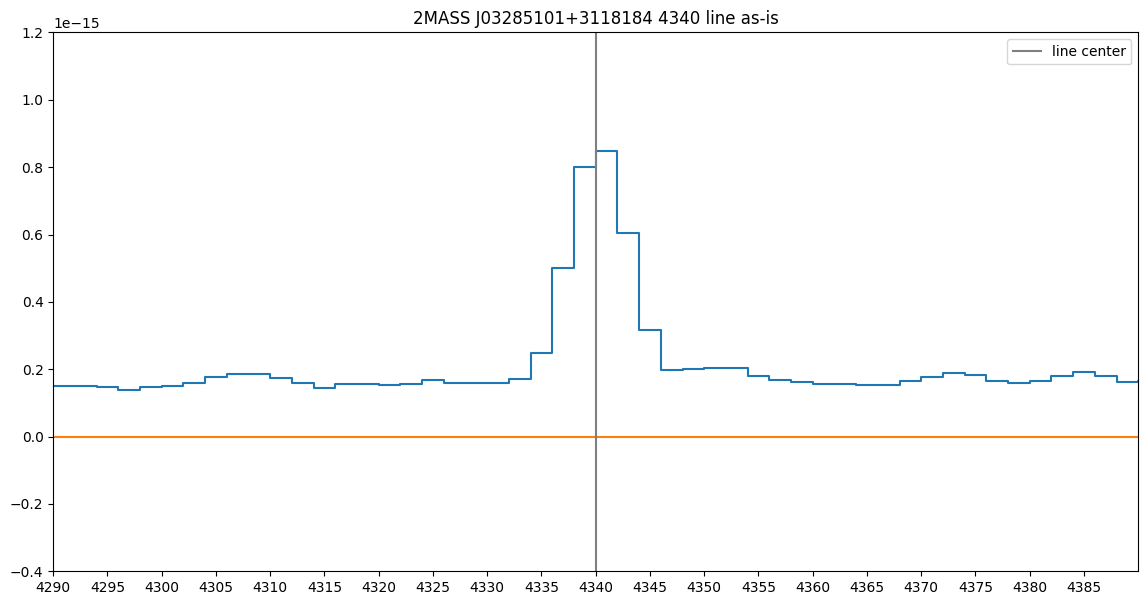

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
INFO: Renormalizing data by factor 1.185419e-17 to improve fitting procedure [pyspeckit.spectrum.fitters]


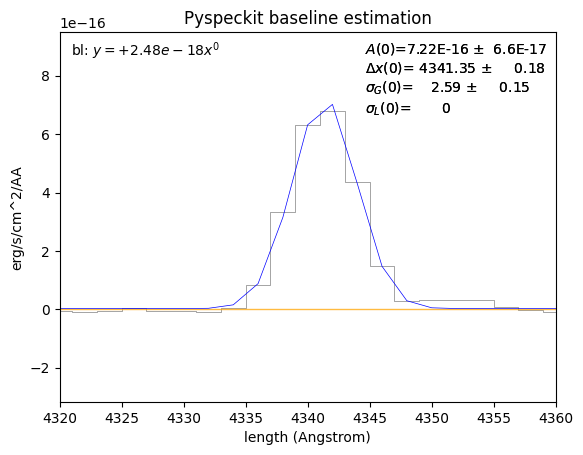

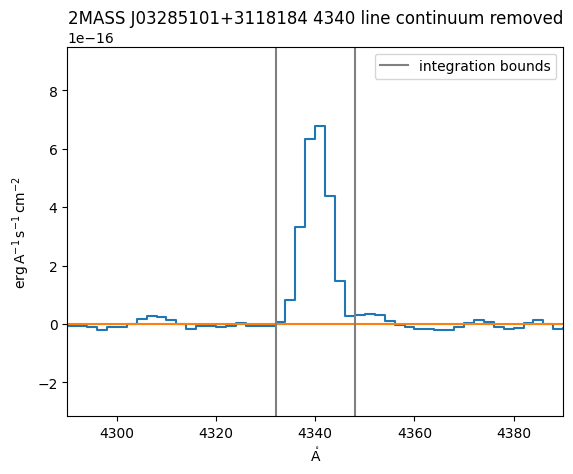

Detected emission line: 
 line_center line_type line_center_index
  Angstrom                             
----------- --------- -----------------
     4342.0  emission                25
average:  4.659572703849829e-15 erg/s/cm2/A  sigma:  3.39810304821079e-16 erg/s/cm2/A 


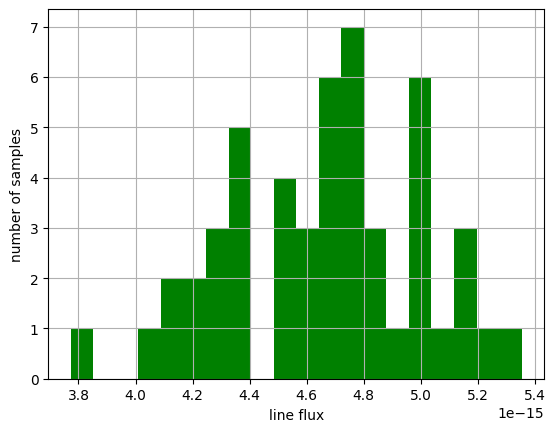

In [9]:
for z in check_lines:

    index_specutils_flux = []
    components = []
    select = (wave>=z-200)*(wave<=z+200) #the wavelength range over which to fit the continuum
    x = np.array(wave)[select]
    flux_array = np.array(flux_YSO[select]) #erg/s/cm2/A
    e = np.array(flux_YSO_err[select])
    degree=1.0 #right now the continuum fit is just set to be a line
    continuum_subt = fit_continuum(x, flux_array, degree, mask)

    #for plotting limits
    upper_y_1 = 1.5*flux_array[(np.where(x==z))[0][0]]
    lower_y_1 = -upper_y_1/3
    upper_y_2 = 1.5*continuum_subt[(np.where(x==z))[0][0]]
    lower_y_2 = -upper_y_2/3
    
    plt.figure(figsize = (14,7))
    plt.step(x, flux_array)
    plt.plot(x, np.zeros(len(x)))
    plt.title(str(ysoname) + ' ' + str(z) + ' line as-is')
    plt.axvline(x=z, c = 'gray', label ='line center')
    plt.xlim(z-50, z+50)
    plt.ylim(lower_y_1, upper_y_1)
    plt.xticks(np.arange(z-50, z+50, 5.0))
    plt.legend()
    plt.show()
                
    left = float(input('left from center (Angstrom): '))
    right = float(input('right from center (Angstrom): '))
        
    #the baseline estimation from pyspeckit-- can be negative if the continuum was overestimated
    sp = p.Spectrum(data= continuum_subt , error = e, xarr=x,
        xarrkwargs={'unit':'angstrom'},
        unit='erg/s/cm^2/AA')
    sp.plotter(xmin=z-20, xmax=z+20, ymin=(lower_y_2), ymax = (upper_y_2), 
            color='grey', title='Pyspeckit baseline estimation') #errstyle='bars'
    sp.baseline(xmin=z-20, xmax=z+20,  
                    exclude=[left,right], 
                    fit_original = False, subtract=False, highlight_fitregion=False, 
                    selectregion=True, order=0, save = False)
    sp.specfit(plot=True, fittype='voigt', color='blue',
            guesses='moments', vheight=True)
    plt.show()
        
    #in case you want to change the bounds of the line
    left_adj = float(input('adjusted left from center (Angstrom): '))
    right_adj = float(input('adjusted right from center (Angstrom): '))
    baseline_value = float(input('baseline (erg/s/cm2/A)): '))
    
    baseline_subt_spec = Spectrum1D(flux= (continuum_subt - baseline_value) * u.Unit('erg cm-2 s-1 A-1'), spectral_axis=x*u.AA) #+10**-16
    f, ax = plt.subplots()  
    ax.step(baseline_subt_spec.spectral_axis, baseline_subt_spec.flux) 
    plt.title(str(ysoname) + ' ' + str(z) + ' line continuum removed')
    plt.plot(x, np.zeros(len(x)))
    plt.xlim(z-50, z+50)
    plt.ylim(lower_y_2 - 2*baseline_value, upper_y_2 - 2*baseline_value)
    plt.axvline(x=left_adj, c = 'gray')
    plt.axvline(x=right_adj, c = 'gray', label = 'integration bounds')
    plt.legend()
    plt.show()
    #output = measure_line_flux(flux_array, x, e, left_adj, right_adj, 50, baseline_value, degree, mask)
    
    x_l = x[x>(z-50)]
    x_tiny = x_l[x_l<(z+50)]
    e_l = e[x>(z-50)]
    e_tiny = e_l[x_l<(z+50)]
    f_l = continuum_subt[x>(z-50)]
    f_tiny = f_l[x_l<(z+50)]

    tiny_uncertainty = StdDevUncertainty(e_tiny)
    tiny_spectrum = Spectrum1D(flux= (f_tiny- baseline_value) * u.Unit('erg cm-2 s-1 AA-1'), spectral_axis= x_tiny *u.AA, uncertainty = tiny_uncertainty)
    found_line = find_lines_threshold(tiny_spectrum, noise_factor=2)
    print('Detected emission line: \n',found_line)
    
    found = False
    if len(found_line['line_center'])== 0:
        found = False
    else:
        for one_line in found_line['line_center'].value:
            if one_line in range(z-3, z+3):
                found = True
                output = measure_line_flux(flux_array, x, e, left_adj, right_adj, 50, baseline_value, degree, mask)
                mu = output[0]
                sigma = output[1]
                index_specutils_flux.append(output)
                components.append(mu)
                if mu<0: #right now I treat absorption as a non-detection, since I'm interested in emission lines
                    found = False
    if found == False:
        e_l = e[x>(z-10)]
        x_l = x[x>(z-10)]
        e_tiny = e_l[x_l<(z+10)]
        rms = 0
        for n in range(0, len(e_tiny)):
             rms += (e_tiny[n])**2
        rms = np.sqrt(rms/len(e_tiny))
        upper_limit = 3 * 20 * rms
        print('upper limit (erg/s/cm2/A): ', upper_limit)